In [2]:
import numpy as np
import scipy as sp
import sys
sys.path.append('/home/brad/code/sdme')
import sdme_logloss as sdme
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
Ndim = 2

trpmat = np.random.randn(2, 2, 2)
k = [0, 0]

def p(x, covmat=[[1, 0.6], [0.6, 1]]):
    
    return np.exp(-np.dot(np.dot(x.transpose(), covmat), x) - np.dot(k, x) )

def p2(x):
    return np.exp(-(x[0]**4 + x[1]**4))

In [9]:
reload(sdme)
init = np.array([0.1, 0.1])
N_samples = 2000
N_burnin = 10000
N_skip = 1000
dx = 1

samples = sdme.mh_sampler(p, Ndim, N_samples, N_burnin, N_skip, init, dx)

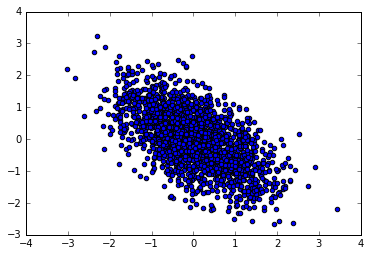

In [10]:
plt.scatter(samples[0, :], samples[1, :])


In [11]:
print(np.dot(samples[0, :], samples[1, :]) / float(N_samples))
print(np.mean(samples[0, :]))

-0.472733542903
0.0282327828613


In [126]:
reload(sdme)
N_neuron = 10
stimlen = 1200
stimdim = 120
N_t = 100
beta_1 = np.random.randn(N_neuron, stimdim)
beta_3= np.random.randn(N_neuron, N_neuron)

stim = np.random.randn(stimdim, stimlen)
resp_vec = 1.0*(np.random.uniform(size=(N_neuron, stimlen)) >0.5)

test = sdme.sdme_p(resp_vec, stim, 1, beta_1, 0, beta_3)

In [ ]:
order = 1
p_params = [stim, order, beta_1, 0, beta_3]
N_samples = 10
N_burnin = 50
N_skip = 10
init = resp_vec
dx = 0

%time tsamps = sdme.parallel_gibbs_sampler2(sdme.sdme_p, N_neuron, stimlen, N_samples, N_burnin, N_skip, init, dx, *p_params )

In [107]:
acc_rate

array([[ 0.22,  0.21,  0.24, ...,  0.22,  0.18,  0.22],
       [ 0.21,  0.2 ,  0.27, ...,  0.29,  0.22,  0.23],
       [ 0.25,  0.28,  0.25, ...,  0.24,  0.24,  0.25],
       ..., 
       [ 0.23,  0.29,  0.19, ...,  0.22,  0.21,  0.26],
       [ 0.23,  0.25,  0.25, ...,  0.27,  0.18,  0.2 ],
       [ 0.26,  0.27,  0.24, ...,  0.22,  0.23,  0.25]])

In [58]:
test = np.random.randn(10, 100)
testind = np.greater(0.5*np.ones((1, 100)), np.random.uniform(size=(1, N_t)))
test[9, testind.flatten()] = test[1, testind.flatten()]


In [79]:
test_sta = sdme.data_to_sta(tsamps, stim)

array([[ 0.00856274,  0.00274063,  0.00955414,  0.00731673,  0.00708436,
         0.00037532, -0.01403857, -0.011658  , -0.00603992,  0.01376391,
        -0.01455324,  0.00836932,  0.00879665,  0.00624132, -0.02016577,
        -0.0135358 ,  0.01731592,  0.00583621, -0.00595444, -0.01463641],
       [-0.00861125,  0.00559926,  0.00582312, -0.00208651, -0.00168391,
         0.01923877,  0.00546037, -0.00748155,  0.00297641,  0.01083186,
         0.0078286 , -0.01208542, -0.01712742, -0.01793349,  0.00222652,
         0.00268924,  0.01577489,  0.00695601,  0.00583606,  0.00228542],
       [-0.00648293, -0.01262145, -0.00207004, -0.01899046, -0.01577123,
        -0.02088928, -0.00373268, -0.00163458, -0.00065571, -0.00275453,
        -0.00417522,  0.00331874, -0.0230554 ,  0.00434093, -0.01845344,
         0.00755896, -0.00534566, -0.00483095, -0.008395  ,  0.00300929],
       [-0.00154699, -0.02685974, -0.01535577, -0.0158641 , -0.02164743,
        -0.02363112,  0.01689588,  0.00756938,  

In [104]:
np.zeros(4)

array([ 0.,  0.,  0.,  0.])